In [1]:
import pandas as pd
import os
from src.data import files_to_df

SOURCE_PATH_ORIG = "data/1_original/txt"
SOURCE_PATH_GEN = "data/2_generated/2step_transformation_dt4h_GPT4omini/en"
ORIG_ENTS = "output/data/ents_orig_scispacy.csv"
GEN_ENTS = "output/data/2step_transformation_dt4h_GPT4omini/en/ents_gen_scispacy.csv"

df_gen = files_to_df(SOURCE_PATH_GEN)
df_gen["filenameid"] = df_gen["filenameid"].str.replace("_transformed_step1", "")

df_orig = files_to_df(SOURCE_PATH_ORIG)
df_pairs = df_orig.merge(df_gen, on="filenameid", suffixes=("_orig", "_gen"))
# assert len(df_pairs) == N_EXPECTED_SAMPLES, f"Expected {N_EXPECTED_SAMPLES} samples, got {len(df_pairs)}"

df_pairs.rename(columns={"text_orig": "clinical_case", "text_gen": "discharge_summary"}, inplace=True)


In [2]:
df_auto = pd.read_csv(ORIG_ENTS)

df_auto

,filenameid,span,mention_class,code,term
0,33175723_1,Amyloid light-chain amyloidosis,DISEASE,C0268381,Primary amyloidosis
1,33175723_1,cardiac amyloidosis,DISEASE,C0268407,Senile cardiac amyloidosis
2,33175723_1,cardiomyopathy,DISEASE,C0878544,Cardiomyopathies
3,33175723_1,heart failure,DISEASE,C0018801,Heart failure
4,33175723_1,AL amyloidosis,DISEASE,C0268381,Primary amyloidosis
...,...,...,...,...,...
33130,37861254,bevacizumab,CHEMICAL,C0796392,bevacizumab
33131,37861254,bevacizumab,CHEMICAL,C0796392,bevacizumab
33132,37861254,palpitation,DISEASE,C0030252,Palpitations
33133,37861254,bevacizumab,CHEMICAL,C0796392,bevacizumab


In [3]:
df_auto_gen = pd.read_csv(GEN_ENTS)
df_auto_gen["filenameid"] = df_auto_gen["filenameid"].str.replace("_transformed_step1", "")
df_auto_merge = df_auto.merge(df_auto_gen, on=["filenameid", "term", "mention_class"], how="outer", suffixes=["_orig", "_gen"])
df_auto_merge = df_auto_merge.drop(columns=["code_orig", "code_gen"])
df_auto_merge = df_auto_merge[["filenameid", "mention_class", "term", "span_orig", "span_gen"]]
df_auto_merge

,filenameid,mention_class,term,span_orig,span_gen
0,25350173,DISEASE,Aneurysm,aneurysm,aneurysm
1,25350173,DISEASE,Cardiac Arrhythmia,arrhythmia,NaN
2,25350173,DISEASE,Cerebrovascular accident,LV stroke,LV stroke
3,25350173,DISEASE,Dyspnea,dyspnoea,Dyspnoea
4,25350173,DISEASE,"Tachycardia, Ventricular",ventricular tachycardia,ventricular tachycardia
...,...,...,...,...,...
53376,39101327,CHEMICAL,hydroxychloroquine,hydroxychloroquine,hydroxychloroquine
53377,39101327,CHEMICAL,mercury,Hg,NaN
53378,39101327,CHEMICAL,putrescine N-hydroxycinnamoyltransferase activity,PHT,NaN
53379,39101327,CHEMICAL,putrescine N-hydroxycinnamoyltransferase activity,PHT,NaN


In [5]:
import re
from typing import List

    
def extract_text_without_sections(text):
    
    
    # text = re.sub(r'\[.*?\]', '', text)  # Remove placeholders

    # Remove section headers (lines with ** at the start and end)
    # text = re.sub(r'\*\*.*?\*\*', '', text)
    
    # # Remove list markers (e.g., "- " or numbered lists)
    # text = re.sub(r'[-\d]+\.\s*', '', text)
    
    # # Remove inline dashes used as separators
    # text = re.sub(r'\s*-\s*', ' ', text)
    
    
    # # Remove extra whitespace and newlines
    # text = re.sub(r'\n+', ' ', text).strip()
    
    return text
    

def split_and_clean(text: str, extract_headers=True) -> List[str]:
    """
    Splits a given text into words and removes punctuation signs.
    
    Args:
        text (str): The input text.
    
    Returns:
        List[str]: A list of words without punctuation.
    """
    if extract_headers:
        text = extract_text_without_sections(text)
    return re.findall(r'\b\w+\b', text)



example = df_pairs["discharge_summary"].iloc[0]
print(example)
print("\n\n")
print(split_and_clean(example))


**Discharge Summary**

**Patient Information:**
- Name: [Patient Name]
- Gender: Male
- Age: 63 years

**Final Diagnosis:**
1. Amyloid light-chain amyloidosis
2. Cardiac amyloidosis
3. Cardiomyopathy
4. Heart failure
5. Primary AL amyloidosis

**Symptoms on Admission:**
- Aphasia
- Dyspnea
- Heart failure
- Thrombosis
- Tongue mass

**Clinical Procedures Performed:**
- Biopsy
- Chemotherapy
- Echocardiography

**Clinical Summary:**
The patient was admitted with newly diagnosed heart failure, characterized by elevated levels of natriuretic peptides and chronically high troponin values. During the course of treatment, the patient experienced transient aphasia, which resolved completely without any structural cerebral damage. An electrocardiogram (ECG) revealed low voltage in the limb leads and a pseudoinfarction pattern in the precordial leads. 

Clinical findings, including periorbital hematoma, a thickened tongue, proteinuria below the nephrotic range, and decreased glomerular filtrati

In [6]:
example = df_pairs["clinical_case"].iloc[0]
print(example)
print("\n\n")
print(split_and_clean(example, extract_headers=False))

Patient: Male, 63-year-old


Final Diagnosis:
• Amyloid light-chain amyloidosis
• cardiac amyloidosis
• cardiomyopathy
• heart failure
• primary AL amyloidosis


Symptoms:
• Aphasia
• dyspnea
• heart failure
• thrombosis
• tongue mass

Clinical Procedure:
• Biopsy
• chemotherapy
• echocardiography

Patient was admitted for newly diagnosed heart failure with high levels of natriuretic peptides and chronically elevated troponin values. During standard treatment, he had experienced transitory aphasia without structural cerebral damage and recovered completely. ECG showed low voltage in the limb leads with a pseudoinfarction pattern in the precordial leads. That finding along with the patient’s clinical presentation (periorbital hematoma, thickened tongue, proteinuria below the nephrotic range, and a decreased glomerular filtration rate) and echo findings were highly suspicious for amyloidosis.

Spontaneous echo contrast was detected in the man’s heart cavities, possibly explaining his rec

In [7]:
from tqdm import tqdm
tqdm.pandas()

df_analysis = df_pairs.copy()
df_analysis["n_words_cc"] = df_analysis["clinical_case"].progress_apply(lambda x: len(split_and_clean(x, extract_headers=False)))
df_analysis["n_words_ds"] = df_analysis["discharge_summary"].progress_apply(lambda x: len(split_and_clean(x, extract_headers=True)))

100%|██████████| 1000/1000 [00:00<00:00, 10689.01it/s]


<Axes: xlabel='n_words_cc', ylabel='n_words_ds'>

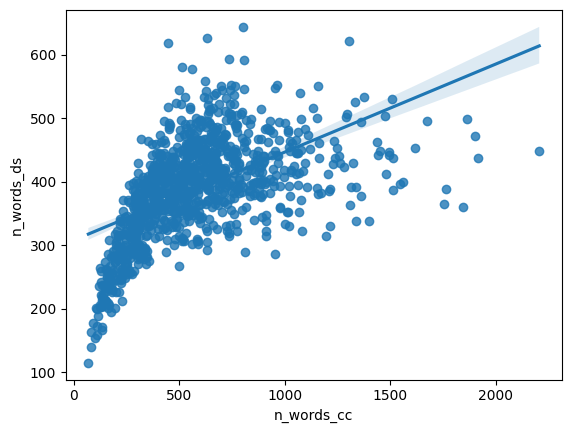

In [8]:
import seaborn as sns

sns.regplot(x="n_words_cc", y="n_words_ds", data=df_analysis)


Text(0.5, 0.98, 'Distribution of generated/original number of words')

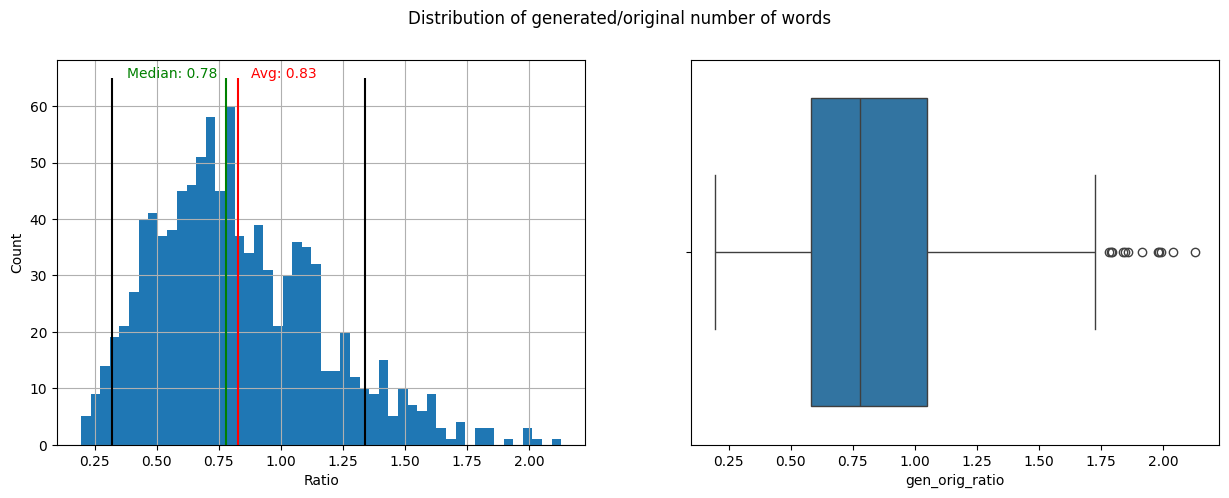

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

df_analysis["gen_orig_ratio"] = df_analysis["n_words_ds"] / df_analysis["n_words_cc"]
df_analysis["gen_orig_ratio"].hist(bins=50, ax=ax[0])

avg_ratio = df_analysis["gen_orig_ratio"].mean()
std_ratio = df_analysis["gen_orig_ratio"].std()
median_ratio = df_analysis["gen_orig_ratio"].median()

ax[0].vlines(x=[avg_ratio, median_ratio, avg_ratio - 1.5 * std_ratio, avg_ratio + 1.5 * std_ratio], ymax=65, ymin=0, colors=["r", "g", "k", "k"])
ax[0].text(x=avg_ratio + 0.05, y=65, fontdict={"color": "r"}, s=f"Avg: {avg_ratio:.2f}")
ax[0].text(x=median_ratio - 0.4, y=65, fontdict={"color": "g"}, s=f"Median: {median_ratio:.2f}")

ax[0].set_xlabel("Ratio")
ax[0].set_ylabel("Count")

sns.boxplot(data=df_analysis, x="gen_orig_ratio", ax=ax[1])
plt.suptitle("Distribution of generated/original number of words")


In [10]:
import numpy as np
df_analysis.select_dtypes(np.number).corr()

,n_words_cc,n_words_ds,gen_orig_ratio
n_words_cc,1.000000,0.543223,-0.855091
n_words_ds,0.543223,1.000000,-0.474170
gen_orig_ratio,-0.855091,-0.474170,1.000000


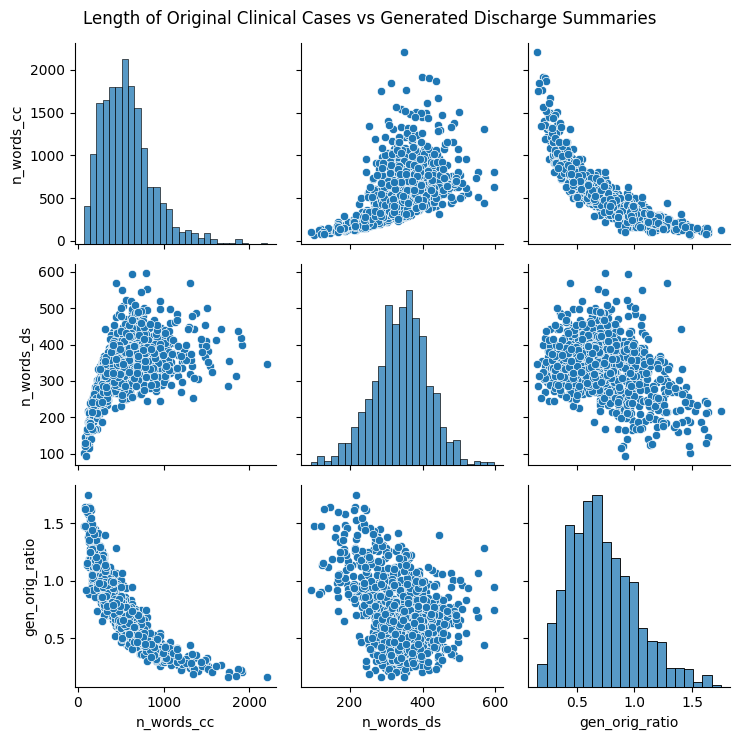

In [19]:
sns.pairplot(df_analysis)
plt.suptitle("Length of Original Clinical Cases vs Generated Discharge Summaries")
plt.tight_layout()

In [11]:
desc = df_analysis["gen_orig_ratio"].describe()
desc

count    1000.000000
mean        0.828498
std         0.339017
min         0.195122
25%         0.581132
50%         0.778715
75%         1.049462
max         2.129032
Name: gen_orig_ratio, dtype: float64

In [12]:
q3 = desc["75%"]
q1 = desc["25%"]
iqr = q3 - q1
up_thres = q3 +  1.5 * iqr
# low_thres = max(q1 - 1.5 * iqr, desc["min"])
# low_thres = q1
low_thres = df_analysis["gen_orig_ratio"].quantile(0.01)
print(up_thres)
print(low_thres)

1.751956268516218
0.25630540493714665


In [14]:
outliers_low = df_analysis[df_analysis["gen_orig_ratio"] < low_thres].sort_values(by="gen_orig_ratio", ascending=True)
outliers_low

,filenameid,clinical_case,discharge_summary,n_words_cc,n_words_ds,gen_orig_ratio
773,33858880,A 21-year-old man initially presented with sho...,**Discharge Summary**\n\n**Patient Information...,1845,360,0.195122
833,30785587,"A 51-year-old male, hypertensive patient, a fo...",**Discharge Summary**\n\n**Patient Information...,2206,448,0.203083
635,38050248,Patient information\nThe case involves a 42-ye...,**Discharge Summary**\n\n**Patient Information...,1754,365,0.208096
193,30226919,The patient is a 60-year-old female with Chaga...,**Discharge Summary**\n\n**Patient Information...,1766,388,0.219706
278,33544806,Clinical history\n\nFour years before the admi...,**Discharge Summary**\n\n**Patient Information...,1918,437,0.227842
487,33263366,We present a 55-year-old woman with a history ...,**Discharge Summary**\n\n**Patient Information...,1400,338,0.241429
563,31378248,A 50-year-old man presented to his primary car...,**Discharge Summary**\n\n**Patient Information...,1901,472,0.248290
817,37885296,A 40-year-old female patient with a history of...,**Discharge Summary**\n\n**Patient Information...,1339,338,0.252427
769,38545376,Patient information\nThe patient was a 16-year...,**Discharge Summary**\n\n**Patient Information...,1560,399,0.255769
764,32111713,A 32 year-old woman was admitted to our instit...,**Discharge Summary**\n\n**Patient Information...,1513,387,0.255783


In [17]:
print(outliers_low.iloc[0]["clinical_case"])

A 21-year-old man initially presented with shortness of breath and abdominal swelling. He was found to be in renal failure with urinary retention and subsequent imaging confirmed severe bilateral hydronephrosis requiring bilateral nephrostomies. He described a 4-month history of progressive shortness of breath on exertion, orthopnoea, weight loss and general malaise. Three months prior to this he had been treated by his general practitioner with a course of oral antibiotics for a productive cough, fevers and shortness of breath. There was no significant past medical history and family history was not suspicious for cardiomyopathy or sudden cardiac death. He was an ex-smoker, having stopped 3 years earlier. Alcohol and illicit drug use were denied, however there was a history of regular ‘Energy drink’ drink consumption, specifically consuming an average of four 500 mL cans per day for approximately 2 years. Each can contains 160 mg of caffeine in addition to taurine and various other in

In [15]:
outliers = df_analysis[df_analysis["gen_orig_ratio"] > up_thres].sort_values(by="gen_orig_ratio", ascending=False)
outliers

,filenameid,clinical_case,discharge_summary,n_words_cc,n_words_ds,gen_orig_ratio
205,30503742_1,"A third patient, a 29-year-old man with histor...",**Discharge Summary**\n\n**Patient Information...,124,264,2.129032
947,26512038,We present a case of a 34-year-old man with ac...,**Discharge Summary**\n\n**Patient Information...,80,163,2.037500
169,29437819,A 67-year-old man with a history of non-ischae...,**Discharge Summary**\n\n**Patient Information...,89,177,1.988764
520,36742441_2,A 70-year-old man with a history of advanced s...,**Discharge Summary**\n\n**Patient Information...,119,236,1.983193
302,30503742_2,"A second patient, a 46-year-old man with nonis...",**Discharge Summary**\n\n**Patient Information...,131,259,1.977099
755,36742441_1,A 71-year-old woman had a history of advanced ...,**Discharge Summary**\n\n**Patient Information...,105,201,1.914286
793,30971480_1,A 67‐year‐old woman with a recurrent leiomyosa...,**Discharge Summary**\n\n**Patient Information...,147,273,1.857143
304,31452187,A 77-year-old woman was hospitalized for acute...,**Discharge Summary**\n\n**Patient Information...,131,242,1.847328
933,31939641,A 39-year-old man with a history of mild inter...,**Discharge Summary**\n\n**Patient Information...,168,309,1.839286
477,35038791_1,The first patient was a 53‐year old male and h...,**Discharge Summary**\n\n**Patient Information...,111,199,1.792793


In [105]:
import numpy as np
for idx, row in outliers_low.iterrows():
    print(row[["filenameid", "n_words_cc", "n_words_ds", "gen_orig_ratio", "n_words_cc", "n_words_ds"]].to_dict())
    
    print("=" * 50)
    
    print(df_auto_merge[df_auto_merge["filenameid"] == row["filenameid"]].fillna(value="None").drop(columns=["filenameid"]).to_markdown())
    # print(np.array(extract_text_without_sections(row["clinical_case"]).split(".")))
    print("=" * 50)

    print(row["clinical_case"])
    
    print("=" * 50)
    
    print(row["discharge_summary"])

    print("=" * 50)
    print("=" * 50)

    print("\n\n")


{'filenameid': '30785587', 'n_words_cc': 2206, 'n_words_ds': 348, 'gen_orig_ratio': 0.15775158658204896}
|      | mention_class   | term                                      | span_orig                          | span_gen                    |
|-----:|:----------------|:------------------------------------------|:-----------------------------------|:----------------------------|
| 8636 | CHEMICAL        | Adrenergic beta-Antagonists               | beta-blocker                       | beta-blocker                |
| 8637 | DISEASE         | Anemia                                    | None                               | anemia                      |
| 8638 | DISEASE         | Anemia                                    | None                               | anemia                      |
| 8639 | DISEASE         | Aneurysm                                  | aneurysm                           | None                        |
| 8640 | DISEASE         | Aneurysm                                

In [89]:
import numpy as np
for idx, row in outliers.iterrows():
    print(row[["filenameid", "n_words_cc", "n_words_ds", "gen_orig_ratio"]].to_dict())
    
    print("=" * 50)
    
    print(df_auto_merge[df_auto_merge["filenameid"] == row["filenameid"]].fillna(value="None").drop(columns=["filenameid"]).to_markdown())
    # print(np.array(extract_text_without_sections(row["clinical_case"]).split(".")))
    print("=" * 50)

    print(row["clinical_case"])
    
    print("=" * 50)
    
    print(row["discharge_summary"])

    print("=" * 50)
    print("=" * 50)

    print("\n\n")


{'filenameid': '30503742_1', 'n_words_cc': 124, 'n_words_ds': 217, 'gen_orig_ratio': 1.75}
|      | mention_class   | term                     | span_orig                  | span_gen                   |
|-----:|:----------------|:-------------------------|:---------------------------|:---------------------------|
| 7054 | DISEASE         | Cardiomyopathies         | None                       | cardiomyopathy             |
| 7055 | DISEASE         | Heart failure            | heart failure              | Heart failure              |
| 7056 | DISEASE         | Heart failure            | heart failure              | heart failure symptoms     |
| 7057 | DISEASE         | Heart failure            | heart failure              | heart failure              |
| 7058 | DISEASE         | Left-Sided Heart Failure | bi-ventricular failure     | bi-ventricular failure     |
| 7059 | DISEASE         | Left-Sided Heart Failure | bi-ventricular failure     | bi-ventricular failure     |
| 7060 | DISE